## Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import os
import joblib

import tensorflow as tf
import re
import random
import tf_keras
from tf_keras.callbacks import EarlyStopping  # Use tf.keras.callbacks
import kagglehub
import zipfile
from transformers import TFAutoModel
import shutil
from datetime import timedelta
try:
  import mplfinance as mpf
except:
  !pip install mplfinance
  import mplfinance as mpf
import io
from PIL import Image
from datetime import timedelta

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.4 MB/s eta 0:00:00


## Downloading the data (Model Never Seen)

In [ ]:
def download_and_extract_data(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/1-hour-multiple-pairs-with-charts")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data(filename="output_latest.zip", filename_output="output")

100%|██████████| 26.2M/26.2M [00:00<00:00, 83.6MB/s]

Extracting files...


Renamed downloaded file to 'output_latest.zip'


## Download and load the data it was trained on to get variables

In [ ]:
def download_and_extract_data_1(filename="output_latest", filename_output="output"):
    """
    Downloads, extracts, and deletes a zip file if it doesn't already exist.

    Args:
        filename: The name of the zip file to download.
        filename_output: The name of the folder to extract the contents to.
    """
    if not os.path.exists(filename_output):
        try:
            # Download the .zip file
            print(f"Downloading '{filename}'...")
            # Get the actual downloaded file path
            downloaded_file_path = kagglehub.dataset_download("sulimantadros/multiple-pairs-datasets-hourly")

            # Rename if necessary (if kagglehub returns a different name)
            if downloaded_file_path != filename:
                os.rename(downloaded_file_path, filename)
                print(f"Renamed downloaded file to '{filename}'")

        except Exception as e:
            print(f"An error occurred: {e}")
    else:
        print(f"File '{filename_output}' already exists. Skipping download and extraction.")

download_and_extract_data_1(filename="output_latest_1.zip", filename_output="output")

# Constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Directories
original_train_dir = '/content/output_latest_1.zip/output_1_hour/output_hourly_price_action_patterns_training_and_validation/train'
original_valid_dir = '/content/output_latest_1.zip/output_1_hour/output_hourly_price_action_patterns_training_and_validation/validation'
original_test_dir = '/content/output_latest_1.zip/output_1_hour/output_hourly_price_action_patterns_testing/test'

# Create balanced test dataset
test_ds = tf_keras.utils.image_dataset_from_directory(
    directory=original_test_dir,
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=False,
    seed=SEED
)

class_names = test_ds.class_names
file_paths = test_ds.file_paths

100%|██████████| 40.4M/40.4M [00:00<00:00, 121MB/s]

Extracting files...


Renamed downloaded file to 'output_latest_1.zip'
Found 1923 files belonging to 3 classes.


## Building the machine learning model

In [ ]:
def count_parameters(model, print_output=True):
  """
  Counts the number of trainable, non-trainable and total parameters of a given model.
  """
  trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.trainable_weights])
  non_trainable_parameters = np.sum([np.prod(layer.shape) for layer in model.non_trainable_weights])
  total_parameters = trainable_parameters + non_trainable_parameters
  if print_output:
    print(f"Model {model.name} parameter counts:")
    print(f"Total parameters: {total_parameters}")
    print(f"Trainable parameters: {trainable_parameters}")
    print(f"Non-trainable parameters: {non_trainable_parameters}")
  else:
    return total_parameters, trainable_parameters, non_trainable_parameters

In [ ]:
def create_model(include_top: bool = False,
                 num_classes: int = 1000,
                 input_shape: tuple[int, int, int] = (224, 224, 3),
                 include_preprocessing: bool = True,
                 trainable: bool = False,
                 dropout: float = 0.2,
                 activation: str = "softmax",
                 base_model: tf_keras.Model = None,
                 model_name: str = "model") -> tf_keras.Model:
  """
  Create an EfficientNetV2 B0 feature extractor model with a custom classifier layer.

  Args:
      include_top (bool, optional): Whether to include the top (classifier) layers of the model.
      num_classes (int, optional): Number of output classes for the classifier layer.
      input_shape (tuple[int, int, int], optional): Input shape for the model's images (height, width, channels).
      include_preprocessing (bool, optional): Whether to include preprocessing layers for image normalization.
      trainable (bool, optional): Whether to make the base model trainable.
      dropout (float, optional): Dropout rate for the global average pooling layer.
      activation (str, optional): Activation function for the output layer.
      model_name (str, optional): Name for the created model.

  Returns:
      tf.keras.Model: A TensorFlow Keras model with the specified configuration.
  """
  if base_model is None:
    print('Base Model is None please enter the based model')
    return None

  if activation == "softmax":
    activation = tf_keras.activations.softmax
  elif activation == "sigmoid":
    activation = tf_keras.activations.sigmoid

  # Freeze the base model (if necessary)
  base_model.trainable = trainable

  # Create input layer
  inputs = tf_keras.Input(shape=input_shape, name="input_layer")

  # Create model backbone (middle/hidden layers)
  x = base_model(inputs, training=trainable)

  # Create output layer (also known as "classifier" layer)
  outputs = tf_keras.layers.Dense(
      units=num_classes,
      activation=activation,
      name="output_layer"
  )(x)

  # Connect input and output layer
  model = tf_keras.Model(inputs=inputs, outputs=outputs, name=model_name)

  return model

## Loading the machine learning model

In [ ]:
# Download the model from Kaggle
model_0_loaded_path = kagglehub.model_download("sulimantadros/updated_logic_1_hourforex_convnextxlarge_88/tensorFlow2/default")

# Move the downloaded directory to the current directory
destination_dir = "./model_0"
if not os.path.exists(destination_dir):
    shutil.move(model_0_loaded_path, destination_dir)


# Full path to the .keras model file
# Parameters
model_0_file = os.path.join(destination_dir, "1", "model_0.keras")
include_top = False
input_shape = (224, 224, 3)
include_preprocessing = True

# 1. Create a model
base_model = tf_keras.applications.ConvNeXtXLarge(
    include_top=include_top,
    weights="imagenet",
    input_shape=input_shape,
    include_preprocessing=include_preprocessing,
    pooling="max"  # Can use this instead of adding tf.keras.layers.MaxPooling2D() to the model
)
model_0_loaded_kaggle = create_model(num_classes=len(class_names), trainable=False, base_model=base_model)

# 2. Compile the model
model_0_loaded_kaggle.compile(optimizer=tf_keras.optimizers.Adam(learning_rate=0.001),
                loss=tf_keras.losses.CategoricalCrossentropy(from_logits=False),  # use from_logits=False if using an activation function in final layer
                metrics=["accuracy"])


  0%|          | 0.00/1.30G [00:00<?, ?B/s]
  0%|          | 1.00M/1.30G [00:00<07:32, 3.08MB/s]
  0%|          | 4.00M/1.30G [00:00<02:07, 10.9MB/s]
  1%|          | 11.0M/1.30G [00:00<00:49, 27.7MB/s]
  1%|          | 16.0M/1.30G [00:00<00:40, 34.1MB/s]
  2%|▏         | 21.0M/1.30G [00:01<01:00, 22.5MB/s]
  2%|▏         | 27.0M/1.30G [00:01<00:47, 28.5MB/s]
  2%|▏         | 32.0M/1.30G [00:01<00:41, 32.5MB/s]
  3%|▎         | 36.0M/1.30G [00:01<00:41, 32.4MB/s]
  3%|▎         | 41.0M/1.30G [00:01<00:37, 36.2MB/s]
  3%|▎         | 45.0M/1.30G [00:01<00:36, 37.0MB/s]
  4%|▍         | 50.0M/1.30G [00:01<00:37, 35.5MB/s]
  4%|▍         | 57.0M/1.30G [00:01<00:30, 43.4MB/s]
  5%|▍         | 65.0M/1.30G [00:02<00:36, 36.3MB/s]
  5%|▌         | 73.0M/1.30G [00:02<00:38, 33.9MB/s]
  6%|▌         | 80.0M/1.30G [00:02<00:32, 39.9MB/s]
  6%|▋         | 85.0M/1.30G [00:02<00:42, 31.0MB/s]
  7%|▋         | 89.0M/1.30G [00:02<00:40, 31.9MB/s]
  7%|▋         | 96.0M/1.30G [00:03<00:33, 39.0MB/s]
 

In [ ]:
# Load the weights
model_0_loaded_kaggle.load_weights('/content/model_0/updated_logic_1_hour_forex_1000_ConvNeXtXLarge_88.keras')

In [ ]:
model_0_results = model_0_loaded_kaggle.evaluate(x=test_ds)
model_0_results

61/61 [==============================] - 44s 592ms/step - loss: 0.5772 - accuracy: 0.7826


[0.5772119164466858, 0.7826312780380249]

## Setting up the backtest and getting the signals from model



In [ ]:
#shutil.rmtree('/content/output_results')

In [ ]:
def pred_on_custom_image(image_path: str,  # Path to the image file
                         model,  # Trained TensorFlow model for prediction
                         target_size: tuple[int, int] = (224, 224),  # Desired size of the image for input to the model
                         class_names: list = None,  # List of class names (optional for plotting)
                         plot: bool = True): # Whether to plot the image and predicted class
  """
  Loads an image, preprocesses it, makes a prediction using a provided model,
  and optionally plots the image with the predicted class.

  Args:
      image_path (str): Path to the image file.
      model: Trained TensorFlow model for prediction.
      target_size (int, optional): Desired size of the image for input to the model. Defaults to 224.
      class_names (list, optional): List of class names for plotting. Defaults to None.
      plot (bool, optional): Whether to plot the image and predicted class. Defaults to True.

  Returns:
     str: The predicted class.
  """

  # Prepare and load image
  custom_image = tf.keras.utils.load_img(
    path=image_path,
    color_mode="rgb",
    target_size=target_size,
  )

  # Turn the image into a tensor
  custom_image_tensor = tf.keras.utils.img_to_array(custom_image)

  # Add a batch dimension to the target tensor (e.g. (224, 224, 3) -> (1, 224, 224, 3))
  custom_image_tensor = tf.expand_dims(custom_image_tensor, axis=0)

  # Make a prediction with the target model
  pred_probs = model.predict(custom_image_tensor, verbose=0)

  # Get the predicted class
  pred_class_index = tf.argmax(pred_probs, axis=-1).numpy()[0]
  pred_class = class_names[pred_class_index]

  # Get the probability of the predicted class
  pred_prob = pred_probs[0][pred_class_index]

  # Plot if we want
  if not plot:
    return pred_class, pred_probs, pred_prob
  else:
    plt.figure(figsize=(5, 3))
    plt.imshow(plt.imread(image_path))
    plt.title(f"pred: {pred_class}\nprob: {tf.reduce_max(pred_probs):.3f}")
    plt.axis("off")


In [ ]:
def get_data_filepath_from_image_path(image_path, root_folder, pair):
  # Extract the base name of the image file
  base_name = os.path.basename(image_path)
  csv_name = base_name.replace(".png", ".csv")
  pair_folder = os.path.join(root_folder, pair)
  pair_data_folder = os.path.join(pair_folder, "data")
  file_path = os.path.join(pair_data_folder, csv_name)
  return file_path

In [ ]:
import pandas as pd

def calculate_profit_or_loss(file_path, pred_class, pair):
    # Load the data
    df = pd.read_csv(file_path)
    df['time'] = pd.to_datetime(df['time'])

    # Entry candle and its values
    entry_candle = df.iloc[11]
    time_value_entry_candle = entry_candle['time']
    close_value_entry_candle = entry_candle['close']

    # Exit candle and its values
    exit_candle = df.iloc[-1]
    exit_candle_time = exit_candle['time']

    # Determine the multiplier based on whether the pair contains JPY
    lot_size = 1000 if "JPY" in pair else 100000

    # Initialize variables
    profit = 0
    triggered = False  # Flag to indicate if -100 has been reached

    # Calculate profit or loss based on prediction class
    if pred_class == "bullish_breakout":
        for i in range(12, len(df)):
            candle = df.iloc[i]
            high_profit = (candle['high'] - entry_candle['close']) * lot_size
            low_profit = (candle['low'] - entry_candle['close']) * lot_size

            if low_profit <= -100:
                profit = -100
                triggered = True
                break  # Exit the loop if -100 is reached
        if not triggered:
            profit = (exit_candle['close'] - entry_candle['close']) * lot_size  # Final profit calculation

    elif pred_class == "bearish_breakout":
        for i in range(12, len(df)):
            candle = df.iloc[i]
            high_profit = (entry_candle['close'] - candle['low']) * lot_size
            low_profit = (entry_candle['close'] - candle['high']) * lot_size

            if low_profit <= -100:
                profit = -100
                triggered = True
                break  # Exit the loop if -100 is reached
        if not triggered:
            profit = (entry_candle['close'] - exit_candle['close']) * lot_size  # Final profit calculation

    # Determine if the prediction was correct or incorrect
    prediction_correct_or_incorrect = None
    if pred_class == "bullish_breakout":
        prediction_correct_or_incorrect = (
            'prediction_correct' if exit_candle['close'] > entry_candle['close'] else 'prediction_incorrect'
        )
    elif pred_class == "bearish_breakout":
        prediction_correct_or_incorrect = (
            'prediction_correct' if exit_candle['close'] < entry_candle['close'] else 'prediction_incorrect'
        )

    # Return relevant data
    return entry_candle, exit_candle, profit, exit_candle_time, time_value_entry_candle, prediction_correct_or_incorrect

In [ ]:
def backtesting_code(root_folder, output_root_folder, model, class_names):
    # Identify all pairs dynamically
    pairs = [
        pair for pair in os.listdir(root_folder) if os.path.isdir(os.path.join(root_folder, pair))
    ]
    print(f"Found pairs: {pairs}")

    for pair in pairs:
      final_results = []
      starting_balance = 10000
      current_balance = starting_balance
      profits = []
      profit_dates = []
      # Initialize a counter
      correct_prediction_count = 0

      print(f"Processing pair: {pair}")
      pair_folder = os.path.join(root_folder, pair)
      pair_charts_folder = os.path.join(pair_folder, "charts")
      pair_data_folder = os.path.join(pair_folder, "data")
      pair_output_folder = os.path.join(output_root_folder, pair)
      os.makedirs(pair_output_folder, exist_ok=True)

      # Step 1: Create an empty DataFrame with specified columns
      columns = ['pair', 'entry_time', 'exit_date', 'profit', 'pred_class', 'file_path', 'image_path']
      new_df = pd.DataFrame(columns=columns)

      # Process all images in the pair's charts folder
      for image_name in os.listdir(pair_charts_folder):
        image_path = os.path.join(pair_charts_folder, image_name)
        file_path = get_data_filepath_from_image_path(image_path, root_folder, pair)
        pred_class, pred_probs, pred_prob = pred_on_custom_image(image_path=image_path,
                                              model=model_0_loaded_kaggle,
                                              class_names=class_names,
                                              plot=False)
        if (pred_class == "bullish_breakout" or pred_class == "bearish_breakout") and pred_prob >= 0.95: #
          entry_candle, exit_candle, profit, exit_candle_time, time_value_entry_candle, prediction_correct_or_incorrect = calculate_profit_or_loss(file_path, pred_class, pair)
          #print(f'Profit {profit} for time {exit_candle_time}')
          row = {'pair': pair, 'entry_time': time_value_entry_candle, 'exit_date': exit_candle_time, 'profit': profit, 'pred_class': pred_class, 'file_path': file_path, 'image_path': image_path}
          new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)
          if prediction_correct_or_incorrect == 'prediction_correct':
            # Increment the counter
            correct_prediction_count += 1

      total_charts = len(os.listdir(pair_charts_folder))

      correct_predictions_percentage = correct_prediction_count/total_charts * 100

      # Ensure 'entry_time' column is a datetime object
      new_df['entry_time'] = pd.to_datetime(new_df['entry_time'], errors='coerce')
      # Sort the DataFrame by 'entry_time' in ascending order
      new_df = new_df.sort_values(by='entry_time', ascending=True)

      # Initialize variables for balance and profit tracking
      starting_balance = 10000  # Starting balance
      current_balance = starting_balance
      profits = []  # To store balance over time
      profit_dates = []  # To store corresponding dates

      # Iterate through the sorted DataFrame to calculate profits
      for _, row in new_df.iterrows():
          profit = row['profit']  # Extract the profit value from the row
          exit_candle_time = row['exit_date']  # Extract the exit date

          # Update balance and record profits
          current_balance += profit
          profits.append(current_balance)
          profit_dates.append(exit_candle_time)

      # Plot profits
      total_profit = current_balance - starting_balance
      plt.figure(figsize=(10, 6))
      plt.plot(profit_dates, profits, marker='o')
      plt.title(f"Profit Over Time for Pair: {pair} - Total Profit: £{total_profit:.2f} - Correct predictions percentage: {correct_predictions_percentage:.2f}%")
      plt.xlabel("Date")
      plt.ylabel("Account Balance (£)")
      plt.grid()
      profit_plot_path = os.path.join(pair_output_folder, f"{pair}_profit_plot.png")
      plt.savefig(profit_plot_path)
      plt.show()

      new_df_csv = os.path.join(pair_output_folder, "bullish_and_bearish_predictions.csv")
      new_df.to_csv(new_df_csv, index=False)

      print(f"Profit plot saved to {profit_plot_path}")

Found pairs: ['EURNZD', 'EURCAD', 'GBPCHF', 'USDJPY', 'NZDUSD', 'NZDCAD', 'NZDCHF', 'CHFJPY', 'CADCHF', 'EURCHF', 'AUDUSD', 'USDCHF', 'GBPAUD', 'AUDCHF', 'USDCAD', 'CADJPY', 'EURJPY', 'AUDCAD', 'GBPCAD', 'EURUSD', 'GBPUSD', 'AUDNZD', 'GBPNZD', 'NZDJPY', 'EURGBP', 'GBPJPY', 'EURAUD', 'AUDJPY']
Processing pair: EURNZD


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


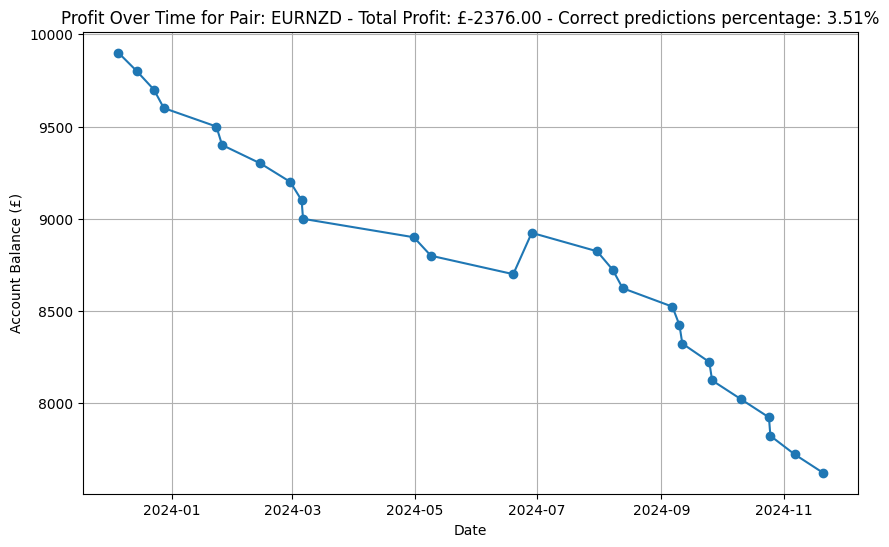

Profit plot saved to /content/output_results/EURNZD/EURNZD_profit_plot.png
Processing pair: EURCAD


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


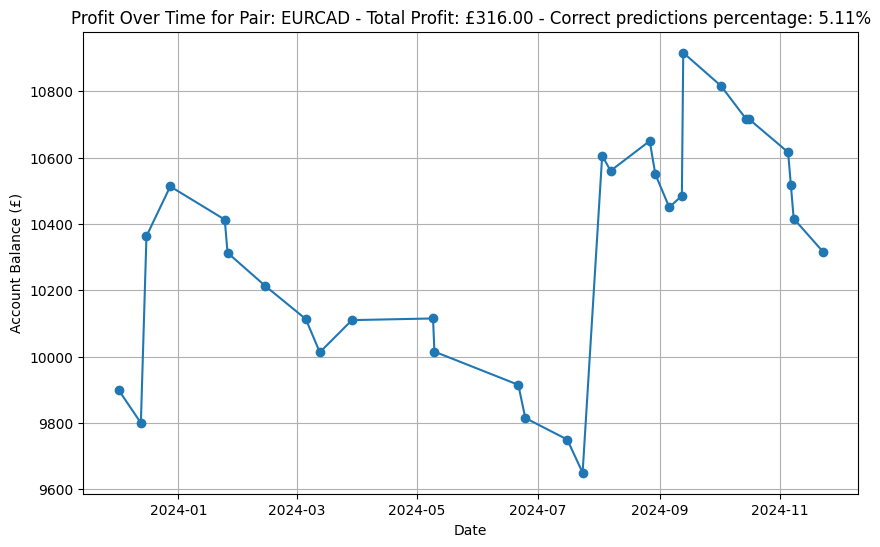

Profit plot saved to /content/output_results/EURCAD/EURCAD_profit_plot.png
Processing pair: GBPCHF


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


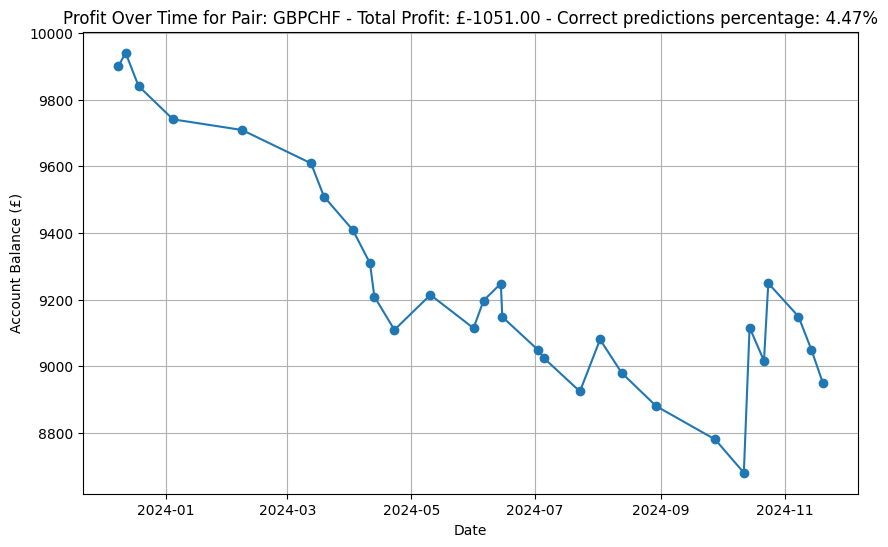

Profit plot saved to /content/output_results/GBPCHF/GBPCHF_profit_plot.png
Processing pair: USDJPY


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


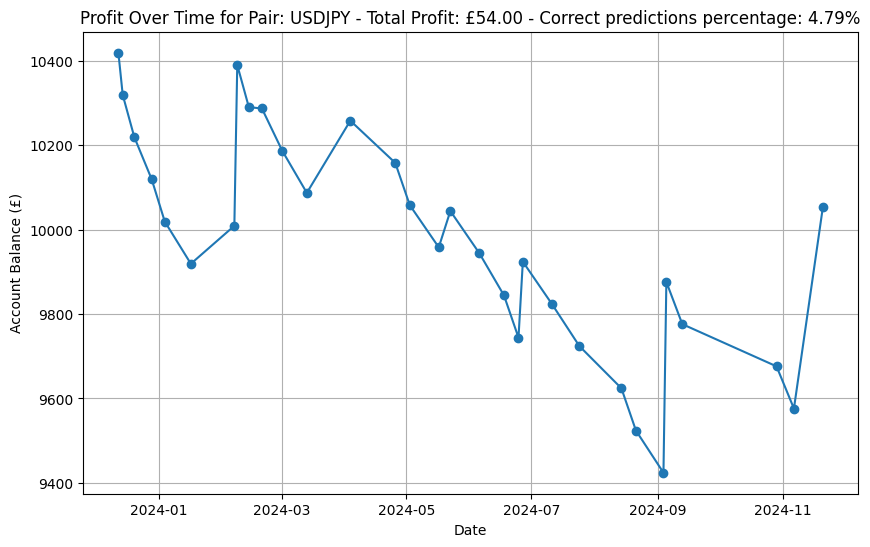

Profit plot saved to /content/output_results/USDJPY/USDJPY_profit_plot.png
Processing pair: NZDUSD


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


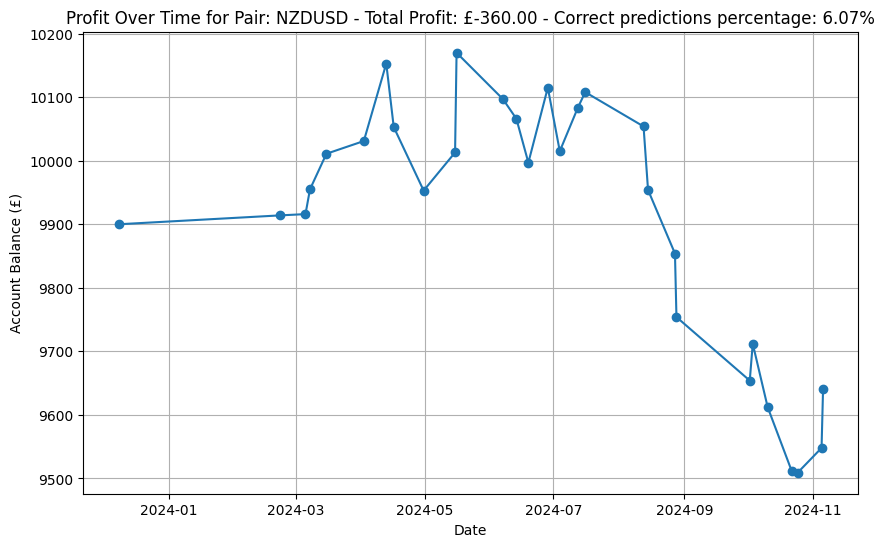

Profit plot saved to /content/output_results/NZDUSD/NZDUSD_profit_plot.png
Processing pair: NZDCAD


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


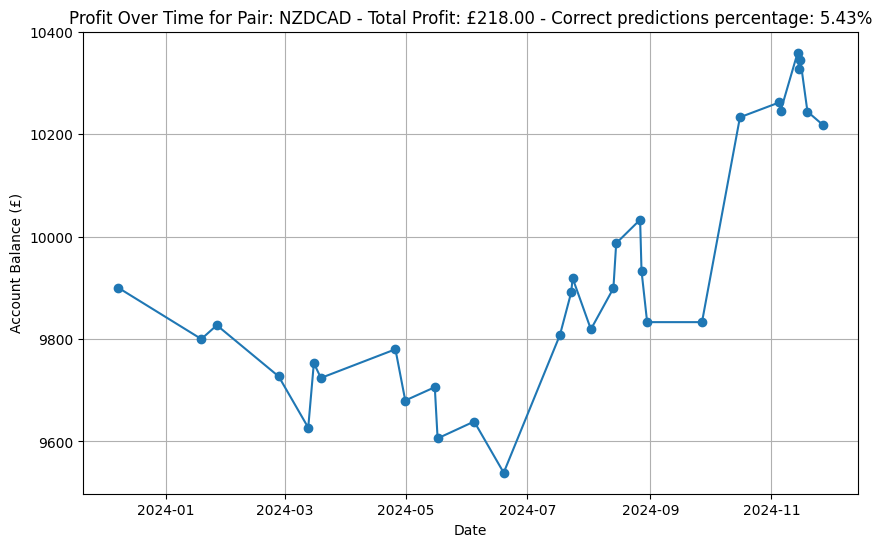

Profit plot saved to /content/output_results/NZDCAD/NZDCAD_profit_plot.png
Processing pair: NZDCHF


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


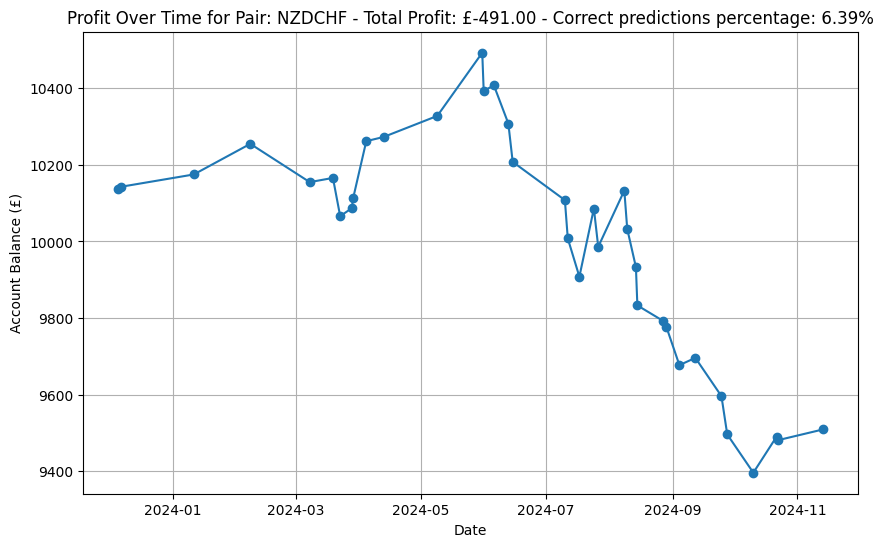

Profit plot saved to /content/output_results/NZDCHF/NZDCHF_profit_plot.png
Processing pair: CHFJPY


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


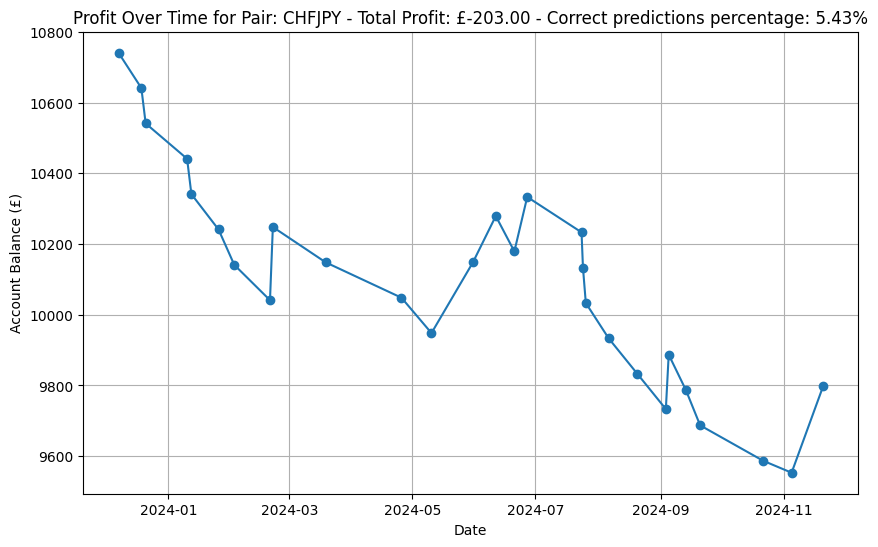

Profit plot saved to /content/output_results/CHFJPY/CHFJPY_profit_plot.png
Processing pair: CADCHF


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


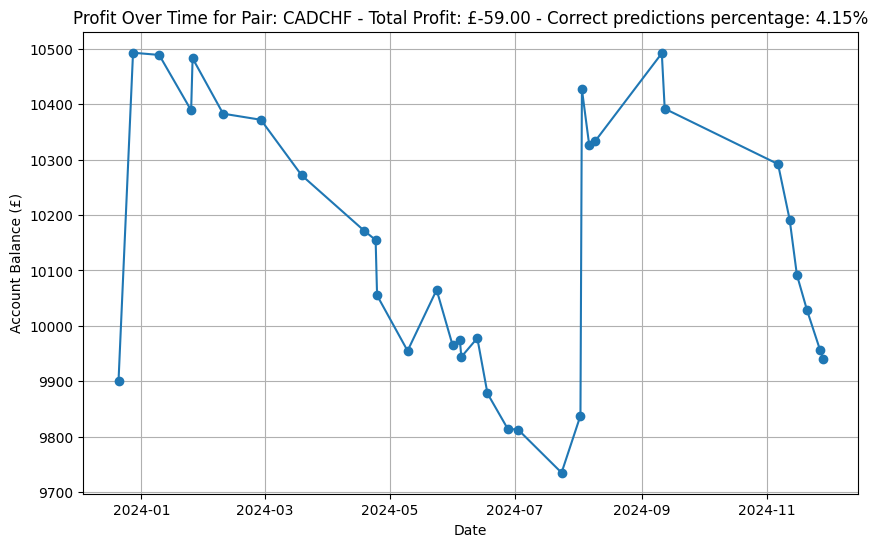

Profit plot saved to /content/output_results/CADCHF/CADCHF_profit_plot.png
Processing pair: EURCHF


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


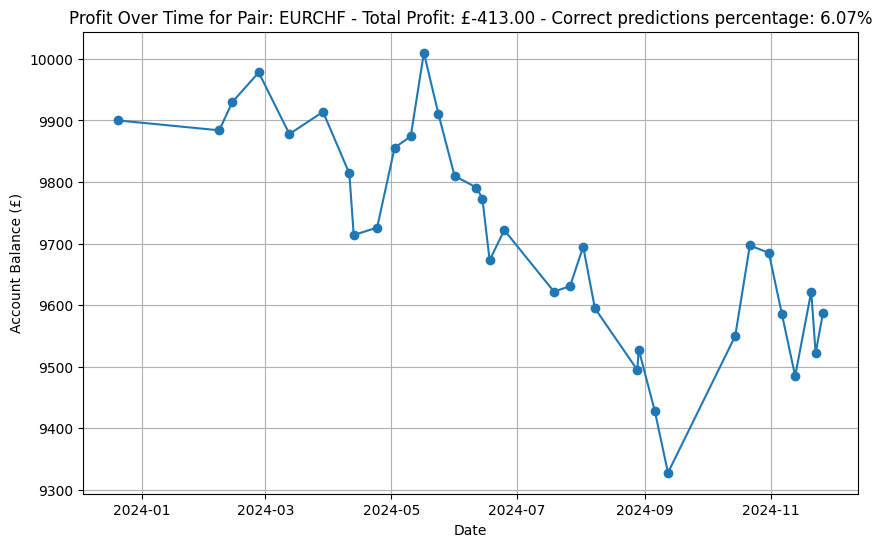

Profit plot saved to /content/output_results/EURCHF/EURCHF_profit_plot.png
Processing pair: AUDUSD


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


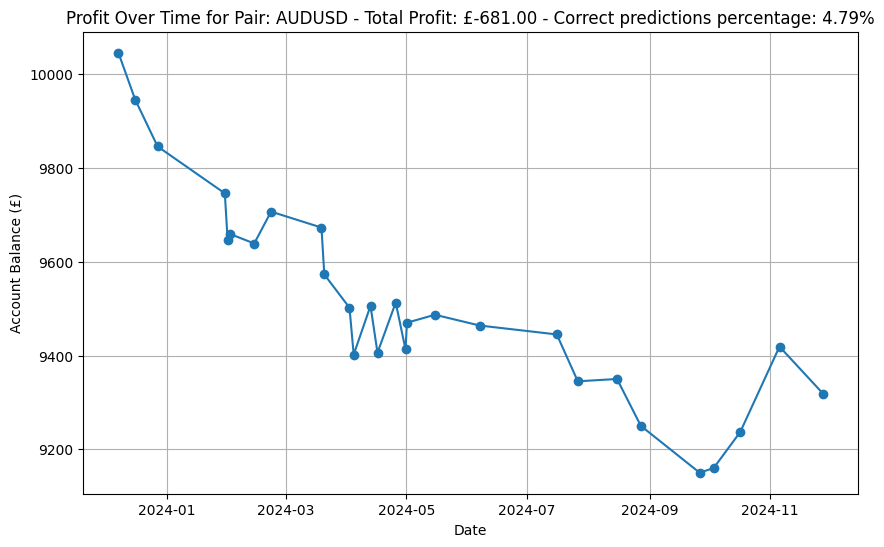

Profit plot saved to /content/output_results/AUDUSD/AUDUSD_profit_plot.png
Processing pair: USDCHF


<ipython-input-67-c115c1f604d5>:40: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([row])], ignore_index=True)


KeyboardInterrupt: 

In [ ]:
data_root = "/content/output_latest.zip/output_specific_symbols_multiple_pairs_1_hour"
output_root = "/content/output_results"

backtesting_code(root_folder=data_root, output_root_folder=output_root, model=model_0_loaded_kaggle, class_names=class_names)

In [ ]:
def show_single_candle(entry_data):
    """
    Display a candlestick chart for a single candle.

    Args:
        entry_data (dict): Dictionary containing candle data with keys:
                           'time', 'open', 'high', 'low', 'close'.
    """
    # Create a DataFrame for the single candle
    single_candle_df = pd.DataFrame([{
        'time': entry_data['time'],
        'open': entry_data['open'],
        'high': entry_data['high'],
        'low': entry_data['low'],
        'close': entry_data['close']
    }])

    print(entry_data['time'])

    # Set 'time' as the index and convert it to a datetime object
    single_candle_df['time'] = pd.to_datetime(single_candle_df['time'])
    single_candle_df.set_index('time', inplace=True)

    # Plot the candlestick chart
    fig, ax = plt.subplots()
    mpf.plot(single_candle_df, type='candle', style='charles', ax=ax)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    plt.show()

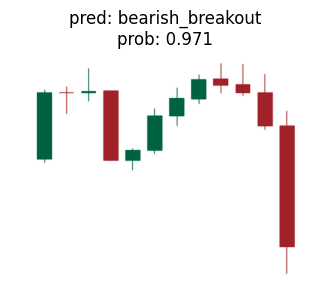

In [ ]:
# Make prediction on custom dog photo 2
pred_on_custom_image(image_path="/content/output_latest.zip/output_specific_symbols_multiple_pairs_1_hour/AUDUSD/charts/AUDUSD_202312150331.png",
                                              model=model_0_loaded_kaggle,
                                              class_names=class_names,)

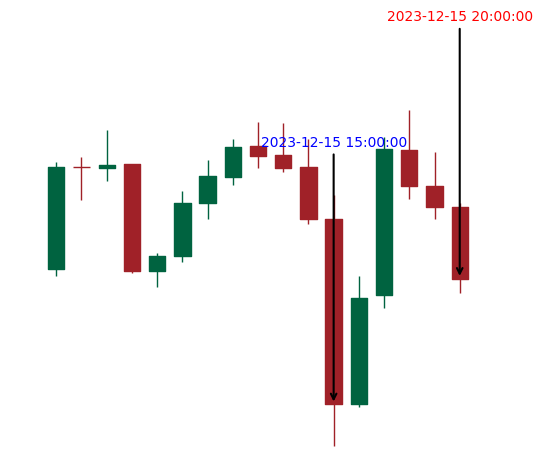

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

def show_chart_with_selected_annotations(df):
    """
    Save a candlestick chart and annotate the 12th and last candles with arrows and their times.
    """
    df = df[['open', 'high', 'low', 'close']].apply(pd.to_numeric, errors='coerce').dropna()

    fig, ax = plt.subplots()
    mpf.plot(df, type='candle', style='charles', ax=ax)

    # Get the 12th and last candles
    if len(df) >= 12:
        twelfth_candle_time = df.iloc[11].name
        twelfth_candle_close = df.iloc[11]['close']
        twelfth_candle_index = 11

        # Annotate the 12th candle with an arrow
        ax.annotate(
            twelfth_candle_time.strftime("%Y-%m-%d %H:%M:%S"),
            xy=(twelfth_candle_index, twelfth_candle_close),
            xytext=(twelfth_candle_index, twelfth_candle_close + 0.005),  # Offset text above the arrow
            fontsize=10,
            ha='center',
            arrowprops=dict(facecolor='blue', arrowstyle='->', lw=1.5),
            color='blue'
        )

    last_candle_index = len(df) - 1
    last_candle_time = df.iloc[-1].name
    last_candle_close = df.iloc[-1]['close']

    # Annotate the last candle with an arrow
    ax.annotate(
        last_candle_time.strftime("%Y-%m-%d %H:%M:%S"),
        xy=(last_candle_index, last_candle_close),
        xytext=(last_candle_index, last_candle_close + 0.005),  # Offset text above the arrow
        fontsize=10,
        ha='center',
        arrowprops=dict(facecolor='red', arrowstyle='->', lw=1.5),
        color='red'
    )

    # Adjust visibility and aesthetics
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    plt.show()

# Load data
df = pd.read_csv('/content/output_latest.zip/output_specific_symbols_multiple_pairs_1_hour/AUDUSD/data/AUDUSD_202312150331.csv')

# Ensure 'time' column is a datetime object
df['time'] = pd.to_datetime(df['time'])

# Set 'time' column as the index
df.set_index('time', inplace=True)

# Show chart with annotations for the 12th and last candles
show_chart_with_selected_annotations(df)